In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import kstest
import pickle

In [2]:
data = pd.read_csv('onehot_bal_fin.csv',dtype={'fullVisitorId': 'str'}).drop(['Unnamed: 0'],axis=1)
data = data.sample(frac = 1, random_state=3).reset_index().drop(['index','date_max','date_min'],axis=1)

df = data.drop_duplicates('fullVisitorId')

In [3]:
col = ['fullVisitorId','totals.transactionRevenue','returned']

classification = RandomForestClassifier(n_estimators=500,min_samples_split=5,min_samples_leaf=2,max_depth=10,n_jobs=-1)
reg = RandomForestRegressor(n_estimators=500,min_samples_split=2,min_samples_leaf=3,max_depth=5,n_jobs=-1)

classification.fit(data.drop(col,axis=1),data['returned'])
reg.fit(df.drop(col,axis=1)[df['returned']==1] ,df['totals.transactionRevenue'][df['returned']==1])

pickle.dump(classification,open('rfc.pkl','wb'))
pickle.dump(reg,open('rfr.pkl','wb'))

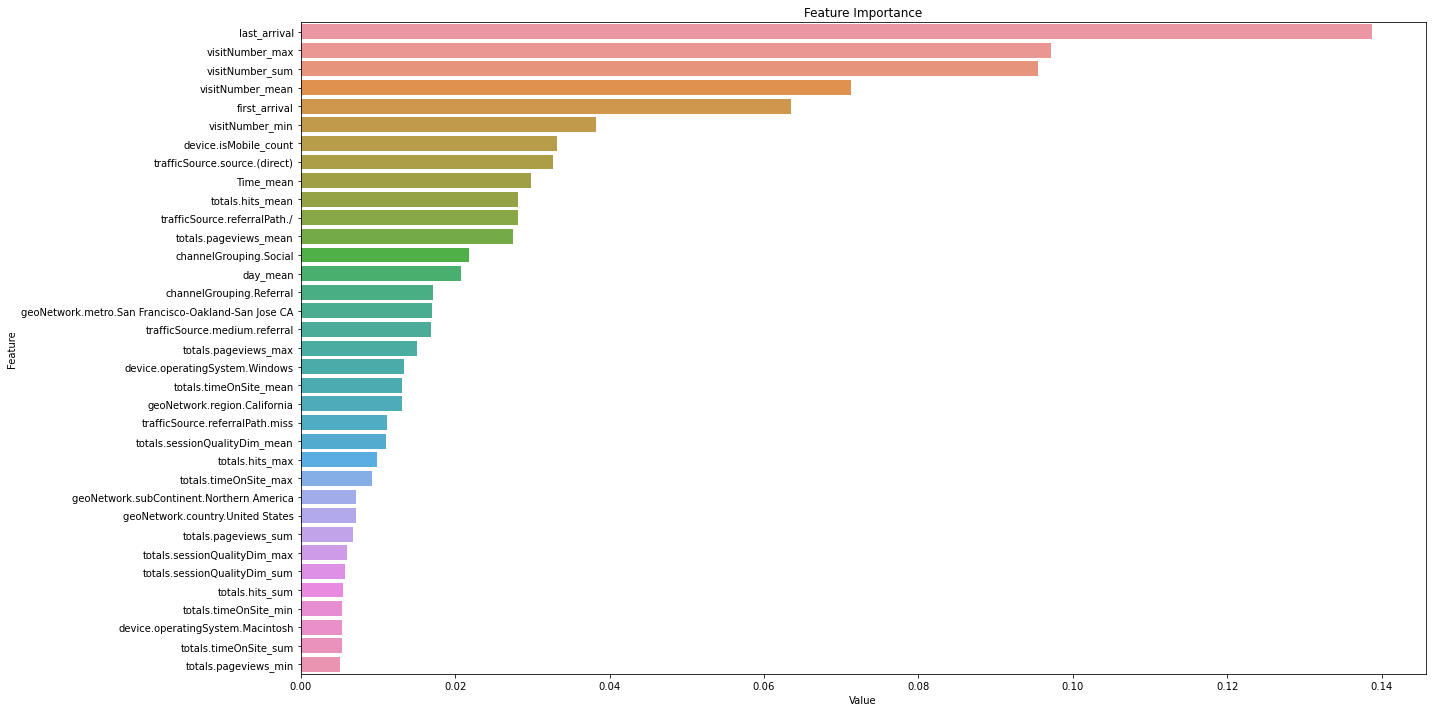

In [4]:
#Classification Feature Importance
d = classification.feature_importances_
cols = df.drop(col,axis=1).columns
fi = pd.DataFrame(zip(cols,d),columns=['Feature','Value']).sort_values(by='Value',ascending=False).reset_index().drop('index',axis=1)

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=fi[fi['Value']>=0.005])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

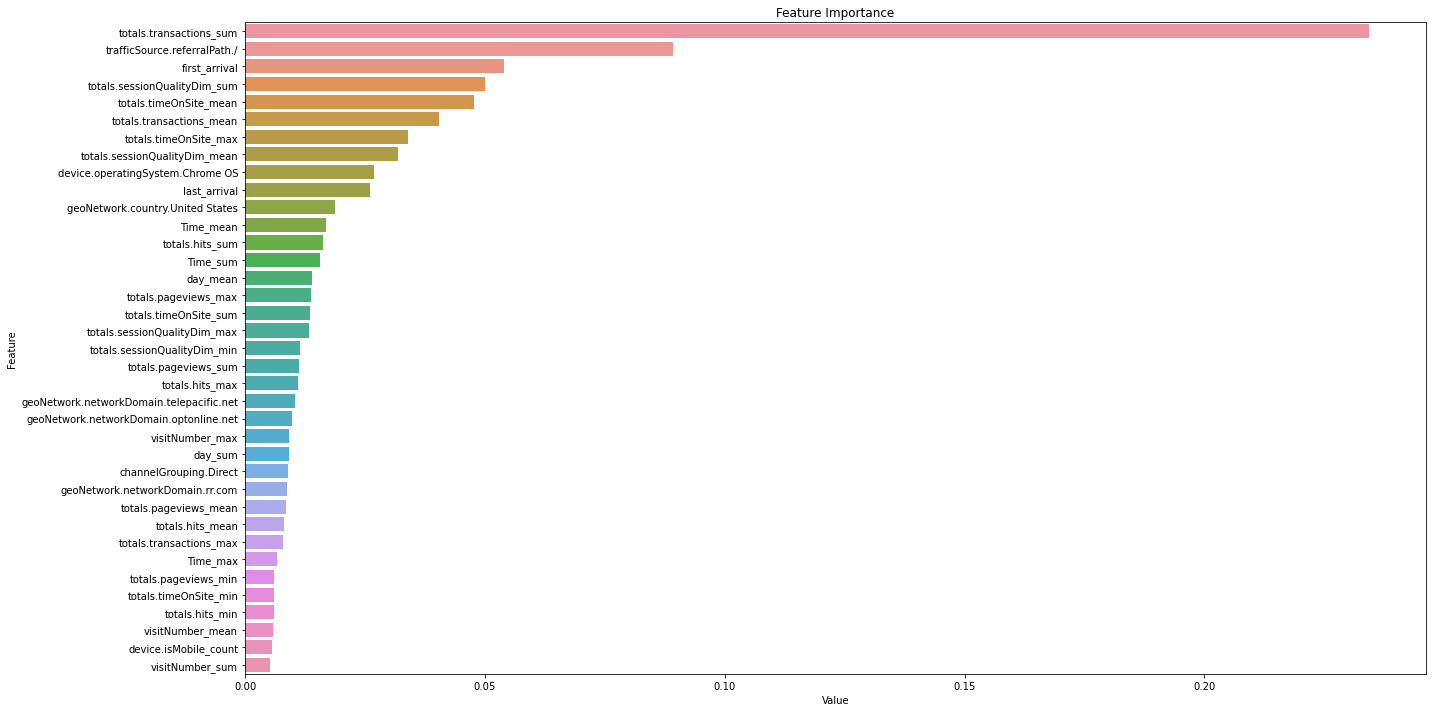

In [5]:
#Regression Feature Importance
d = reg.feature_importances_
cols = df.drop(col,axis=1).columns

fi = pd.DataFrame(zip(cols,d),columns=['Feature','Value'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=fi.sort_values(by="Value", ascending=False)[fi['Value']>=0.005])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [6]:
train_class = classification.predict(df.drop(col,axis=1))
class_res = classification.predict_proba(df.drop(col, axis=1))
reg_res = reg.predict(df.drop(col, axis=1))

df['Pred_class'] = train_class
df['Pred_prob'] = class_res[:,1]
df['Pred_Rev'] = reg_res

## Classification Analysis

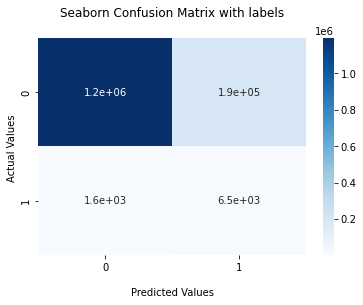

In [7]:
cf_matrix = confusion_matrix(df['returned'], df['Pred_class'])
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show()

### Probability Split of False Positive

Max Probability of fp point: 0.9809593654622215
Min Probability of fp point: 0.5000003684437657

%data points between 0.5-0.6 of Probability:  41.16386526484966
%data points between 0.6-0.7 of Probability:  25.432573185871252
%data points between 0.7-0.8 of Probability:  17.778899597690195
%data points between 0.8-0.9 of Probability:  12.949636581860515
%data points greater than 0.9 of Probability:  2.6750253697283766


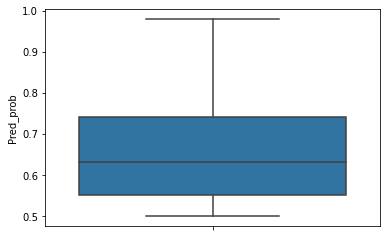

In [8]:
fp = df[df['returned']==0][df['Pred_class']==1]
print('Max Probability of fp point:',max(fp['Pred_prob']))
print('Min Probability of fp point:',min(fp['Pred_prob']))

print('\n%data points between 0.5-0.6 of Probability: ',100*fp[fp['Pred_prob']<=0.6].shape[0]/fp.shape[0])
print('%data points between 0.6-0.7 of Probability: ',100*fp[fp['Pred_prob']<=0.7][fp['Pred_prob']>0.6].shape[0]/fp.shape[0])
print('%data points between 0.7-0.8 of Probability: ',100*fp[fp['Pred_prob']<=0.8][fp['Pred_prob']>0.7].shape[0]/fp.shape[0])
print('%data points between 0.8-0.9 of Probability: ',100*fp[fp['Pred_prob']<=0.9][fp['Pred_prob']>0.8].shape[0]/fp.shape[0])
print('%data points greater than 0.9 of Probability: ',100*fp[fp['Pred_prob']>0.9].shape[0]/fp.shape[0])

sns.boxplot(y=fp['Pred_prob'])
plt.show()

40% of our False positives are in the range 0.5 to 0.6

### Probability Split of False Negative

Max Probability of fn point: 0.49995961950728224
Min Probability of fn point: 0.0335807430076092

%data points between 0-0.1 of Probability:  1.8902439024390243
%data points between 0.1-0.2 of Probability:  10.975609756097562
%data points between 0.2-0.3 of Probability:  24.634146341463413
%data points between 0.3-0.4 of Probability:  20.426829268292682
%data points greater than 0.4 of Probability:  42.073170731707314


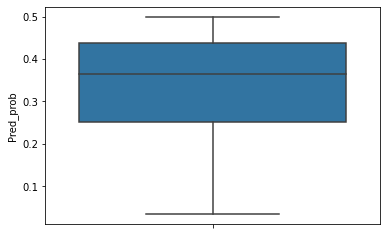

In [9]:
fp = df[df['returned']==1][df['Pred_class']==0]
print('Max Probability of fn point:',max(fp['Pred_prob']))
print('Min Probability of fn point:',min(fp['Pred_prob']))

print('\n%data points between 0-0.1 of Probability: ',100*fp[fp['Pred_prob']<=0.1].shape[0]/fp.shape[0])
print('%data points between 0.1-0.2 of Probability: ',100*fp[fp['Pred_prob']<=0.2][fp['Pred_prob']>0.1].shape[0]/fp.shape[0])
print('%data points between 0.2-0.3 of Probability: ',100*fp[fp['Pred_prob']<=0.3][fp['Pred_prob']>0.2].shape[0]/fp.shape[0])
print('%data points between 0.3-0.4 of Probability: ',100*fp[fp['Pred_prob']<=0.4][fp['Pred_prob']>0.3].shape[0]/fp.shape[0])
print('%data points greater than 0.4 of Probability: ',100*fp[fp['Pred_prob']>0.4].shape[0]/fp.shape[0])

sns.boxplot(y=fp['Pred_prob'])
plt.show()

40% of our False Negatives are in greater than 0.4

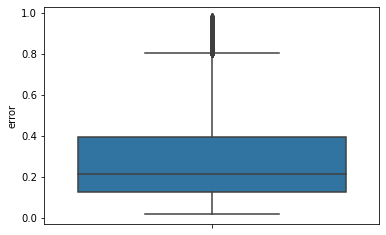

In [10]:
df['error'] = abs(df['returned']-df['Pred_prob'])
sns.boxplot(y=df['error'])
plt.show()

Data points with error >0.8 seems to be outliers

In [11]:
d = classification.feature_importances_
cols = df.drop(col,axis=1).columns

fi = pd.DataFrame(zip(cols,d),columns=['Feature','Value']).sort_values(by='Value',ascending=False).reset_index().drop('index',axis=1)
feat = list(fi[fi['Value']>0.01]['Feature'])

In [12]:
crr = df[df['error']<0.5]
crr = crr.reset_index().drop('index',axis=1)

err = df[df['error']>=0.5]
err = err.reset_index().drop('index',axis=1)

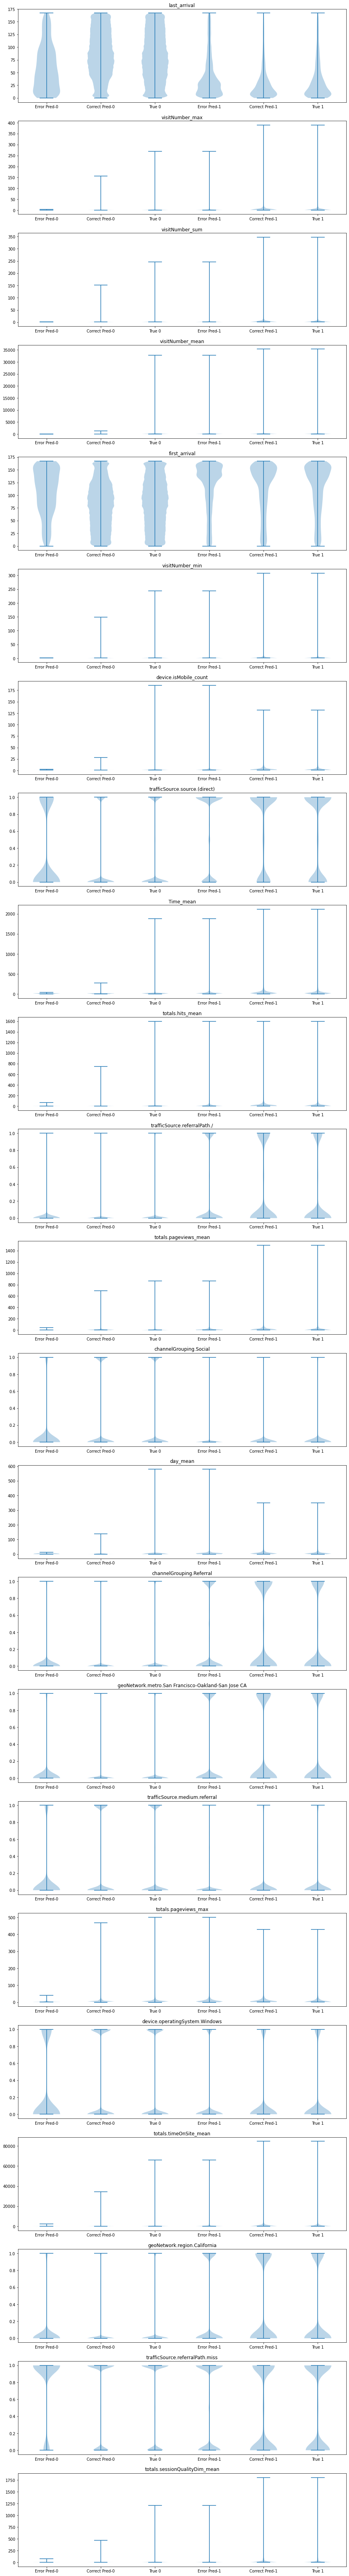

In [13]:
fig,ax=plt.subplots(nrows=len(feat), ncols=1,figsize=(15,120))
for i in range(len(feat)):
    ax[i].violinplot([err[feat[i]][err['Pred_class']==0],crr[feat[i]][crr['Pred_class']==0],df[feat[i]][df['returned']==0],\
                      err[feat[i]][err['Pred_class']==1],crr[feat[i]][crr['Pred_class']==1],df[feat[i]][df['returned']==1]],vert=True)
    ax[i].set_xticklabels(['','Error Pred-0','Correct Pred-0','True 0','Error Pred-1','Correct Pred-1','True 1']) 
    ax[i].set_title(feat[i])
plt.show()

The Error Pred 0,Correct Pred 0 and True 0 have the same distribution and Error Pred 1,Correct Pred 1 and True 1 also have the same distribution.

To get a quantitative view we can use the D Statistic of KS test. The D statistic is the absolute max distance (supremum) between the CDFs of the two samples. The closer this number is to 0 the more likely it is that the two samples were drawn from the same distribution.

In [14]:
wc01 = []
wc10 = []
for i in range(len(feat)):
    stat,_ = kstest(err[feat[i]][err['Pred_class']==1],df[feat[i]][df['returned']==1])
    wc01.append(stat)
    
    stat,_ = kstest(err[feat[i]][err['Pred_class']==0],df[feat[i]][df['returned']==0])
    wc10.append(stat)
    
dist = pd.DataFrame(zip(feat,wc01,wc10),columns=['Feature','Wrong Pred 0','Wrong Pred 1'])
dist

,Feature,Wrong Pred 0,Wrong Pred 1
0,last_arrival,0.121496,0.173926
1,visitNumber_max,0.121762,0.096656
2,visitNumber_sum,0.132359,0.096656
3,visitNumber_mean,0.108785,0.097370
4,first_arrival,0.043364,0.181268
5,visitNumber_min,0.099925,0.020234
6,device.isMobile_count,0.066142,0.085072
7,trafficSource.source.(direct),0.042025,0.067209
8,Time_mean,0.062598,0.061809
9,totals.hits_mean,0.067718,0.060024


Here we can see as a quantitative measure on how similar the data of wrongly predicted is to that of correct predictions. 

Summary:
1. Because we have very few data points which were of class 1 (customer returned), our model was not able to learn the details.
2. For 5% our datapoints the model stongly believes that they fall in the other class, which maybe we can remove from our data.

## Regression Analysis

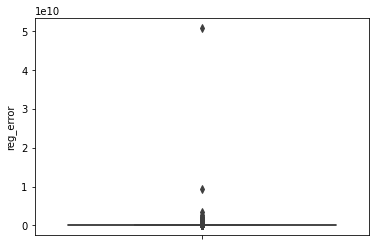

In [15]:
df['reg_error'] = abs(np.expm1(df['totals.transactionRevenue'])-np.expm1(df['Pred_Rev'])) # exact transaction value - exact predicted
sns.boxplot(y=df['reg_error'])
plt.show()

In [16]:
for i in range(0,101,10):
    print(i,'Percentile of Reg_Error: ',np.percentile(df['reg_error'],i))

0 Percentile of Reg_Error:  0.06620254102738245
10 Percentile of Reg_Error:  0.06687450555298874
20 Percentile of Reg_Error:  0.06745412688062563
30 Percentile of Reg_Error:  0.06858205604375193
40 Percentile of Reg_Error:  0.07474369369894522
50 Percentile of Reg_Error:  0.08123304313652244
60 Percentile of Reg_Error:  0.22183736737395987
70 Percentile of Reg_Error:  0.7724295554148352
80 Percentile of Reg_Error:  0.9072595788300697
90 Percentile of Reg_Error:  1.2542574193806988
100 Percentile of Reg_Error:  50941848929.62942


In [17]:
for i in range(90,101,1):
    print(i,'Percentile of Reg_Error: ',np.percentile(df['reg_error'],i))

90 Percentile of Reg_Error:  1.2542574193806988
91 Percentile of Reg_Error:  1.402644446820382
92 Percentile of Reg_Error:  1.6963836520079707
93 Percentile of Reg_Error:  2.0311924938999235
94 Percentile of Reg_Error:  2.1415340324959256
95 Percentile of Reg_Error:  2.337918182727483
96 Percentile of Reg_Error:  2.6484750464093967
97 Percentile of Reg_Error:  4.015967207882295
98 Percentile of Reg_Error:  6.554927550346575
99 Percentile of Reg_Error:  20.98886519573889
100 Percentile of Reg_Error:  50941848929.62942


98% of our data has an error below $10

In [18]:
crr = df[df['reg_error']<10]
crr = crr.reset_index().drop('index',axis=1)

err = df[df['reg_error']>=10]
err = err.reset_index().drop('index',axis=1)

In [19]:
d = reg.feature_importances_
cols = df.drop(col,axis=1).columns

fi = pd.DataFrame(zip(cols,d),columns=['Feature','Value']).sort_values(by='Value',ascending=False).reset_index().drop('index',axis=1)
feat = list(fi[fi['Value']>0.01]['Feature'])
len(feat)

22

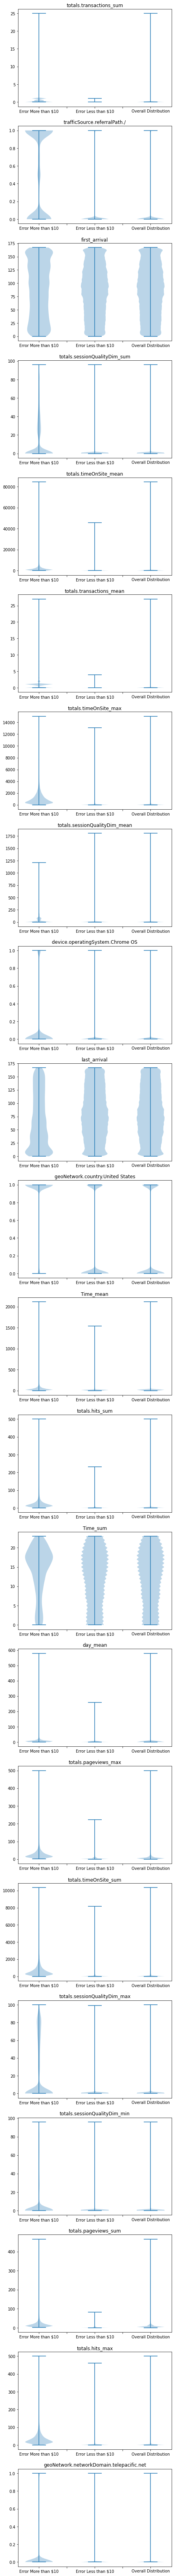

In [20]:
fig,ax=plt.subplots(nrows=len(feat), ncols=1,figsize=(7,120))
for i in range(len(feat)):
    ax[i].violinplot([err[feat[i]],crr[feat[i]],df[feat[i]]],vert=True)
    ax[i].set_xticklabels(['','Error More than $10','','Error Less than $10','','Overall Distribution']) 
    ax[i].set_title(feat[i])
plt.show()

We can observe the distribution of Data for Error Less than $\$$10 is more similar to overall distribution of data compared to distribution of Error More than $10 for the important features. To quatify this we will use the D-statistic from ks-test

In [21]:
wc01 = []
wc10 = []
for i in range(len(feat)):
    stat,_ = kstest(err[feat[i]],df[feat[i]])
    wc01.append(stat)
    
    stat,_ = kstest(crr[feat[i]],df[feat[i]])
    wc10.append(stat)
    
dist = pd.DataFrame(zip(feat,wc01,wc10),columns=['Feature','Error>10','Error<10'])
dist

,Feature,Error>10,Error<10
0,totals.transactions_sum,0.593971,0.008694
1,trafficSource.referralPath./,0.524618,0.007679
2,first_arrival,0.064770,0.000948
3,totals.sessionQualityDim_sum,0.362162,0.005301
4,totals.timeOnSite_mean,0.770075,0.011272
5,totals.transactions_mean,0.593971,0.008694
6,totals.timeOnSite_max,0.765373,0.011203
7,totals.sessionQualityDim_mean,0.360743,0.005280
8,device.operatingSystem.Chrome OS,0.077187,0.001130
9,last_arrival,0.141750,0.002075


Like we said before the data with Error less than $\$$10 is very similar to overall distribution we had, of Important features.

# Summary

1. Our Classification and Regression Models learned perfectly the distribution of data.
2. In some cases behavoiur of Customers who are spending/returning is very similar to who are not returning/spending. In short there is some overlap between the customers who are returning and spending to who are not returning or spending.
3. Higher number of records where customers returned could have made the model even more finer. In our case the ratio was 98:2, beacuse of which we had to Oversample, which led to model not being able to learn new things.